#### Analyzing Neural Time Series Data
Python code for Chapter 9 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [60]:
# Import necessary libraries
# Note: The following code requires the MNE library for topographical plotting.
# If MNE is not installed, you can install it using pip:
# !pip install mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import griddata
from scipy.signal import filtfilt, firwin
from mne.viz import plot_topomap
from mne.channels import read_layout

In [90]:
# Load EEG data
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]  # Extract the EEG structure

# Define helper functions
def get_channel_index(channel_label, chanlocs):
    """Return the index of the channel with the given label."""
    labels = [chanlocs[i][0][0] for i in range(chanlocs.size)]
    return labels.index(channel_label)

def get_eeg_times(EEG):
    """Return the EEG times array."""
    return EEG['times'][0]

def get_eeg_data(EEG, channel_index=None):
    """Return the EEG data array, optionally for a specific channel."""
    data = EEG['data']
    if channel_index is not None:
        data = data[channel_index, :, :]
    return data

def get_eeg_trials(EEG):
    """Return the number of trials in the EEG data."""
    return EEG['trials'][0][0]

def get_eeg_srate(EEG):
    """Return the sampling rate of the EEG data."""
    return EEG['srate'][0][0]

def get_eeg_chanlocs(EEG):
    """Return the EEG channel locations."""
    return EEG['chanlocs'][0]

def plot_random_trials(EEG, channel_index, num_trials, x_axis_limit):
    """Plot random trials from a specific channel."""
    times = get_eeg_times(EEG)
    data = get_eeg_data(EEG, channel_index)
    trials = get_eeg_trials(EEG)
    
    fig, axs = plt.subplots(int(np.ceil(num_trials / np.ceil(np.sqrt(num_trials)))), 
                            int(np.ceil(np.sqrt(num_trials))), figsize=(12, 8))
    axs = axs.flatten()
    
    for i in range(num_trials):
        random_trial = np.random.choice(trials, 1)
        axs[i].plot(times, data[:, random_trial].flatten())
        axs[i].set_xlim(x_axis_limit)
        axs[i].set_title(f'Trial {random_trial[0]}')
        axs[i].set_yticklabels([])
    plt.tight_layout()
    plt.show()

def plot_erp(EEG, channel_index):
    """Plot the Event-Related Potential (ERP) from a specific channel."""
    times = get_eeg_times(EEG)
    data = get_eeg_data(EEG, channel_index)
    erp = np.mean(data, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(times, erp, 'k', linewidth=2)
    plt.axhline(0, color='k')
    plt.axvline(0, color='k', linestyle=':')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (μV)')
    plt.title(f'ERP from electrode {EEG["chanlocs"][0][channel_index][0][0]}')
    plt.gca().invert_yaxis()
    plt.show()

def plot_filtered_erp(EEG, channel_label):
    """Plot filtered ERPs from a specific channel."""
    chanlocs = get_eeg_chanlocs(EEG)
    channel_index = get_channel_index(channel_label, chanlocs)
    erp = np.mean(get_eeg_data(EEG, channel_index), axis=1)
    srate = get_eeg_srate(EEG)
    times = get_eeg_times(EEG)
    
    # Define filter parameters
    nyquist = srate / 2
    transition_width = 0.15
    
    # Filter from 0-40 Hz
    filter_cutoff = 40
    filterweights = firwin(101, filter_cutoff / nyquist)
    erp_0to40 = filtfilt(filterweights, 1, erp)
    
    # Filter from 0-10 Hz
    filter_cutoff = 10
    filterweights = firwin(101, filter_cutoff / nyquist)
    erp_0to10 = filtfilt(filterweights, 1, erp)
    
    # Filter from 5-15 Hz
    filter_low = 5
    filter_high = 15
    filterweights = firwin(round(3 * (srate / filter_low)) + 1, [filter_low, filter_high], pass_zero=False, fs=srate)
    erp_5to15 = filtfilt(filterweights, 1, erp)
    
    # Plot all filtered ERPs
    plt.figure(figsize=(10, 5))
    plt.plot(times, erp, 'k', label='None')
    plt.plot(times, erp_0to40, 'b', linewidth=2, label='0-40 Hz')
    plt.plot(times, erp_0to10, 'r', label='0-10 Hz')
    plt.plot(times, erp_5to15, 'm', label='5-15 Hz')
    plt.xlim([-200, 1200])
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (μV)')
    plt.title(f'ERP from electrode {channel_label}')
    plt.legend()
    plt.show()

def plot_butterfly_topo_variance(EEG):
    """Plot butterfly plot and topographical variance."""
    times = get_eeg_times(EEG)
    data = get_eeg_data(EEG)
    mean_data = np.mean(data, axis=2)
    
    plt.figure(figsize=(10, 8))
    
    # Butterfly plot
    plt.subplot(2, 1, 1)
    for channel_data in mean_data:
        plt.plot(times, channel_data)
    plt.xlim([-200, 1000])
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (μV)')
    plt.title('ERP from all sensors')
    plt.gca().invert_yaxis()
    
    # Topographical variance plot
    plt.subplot(2, 1, 2)
    plt.plot(times, np.var(mean_data, axis=0))
    plt.xlim([-200, 1000])
    plt.xlabel('Time (ms)')
    plt.ylabel('Variance (μV²)')
    plt.title('Topographical variance')
    plt.tight_layout()
    plt.show()

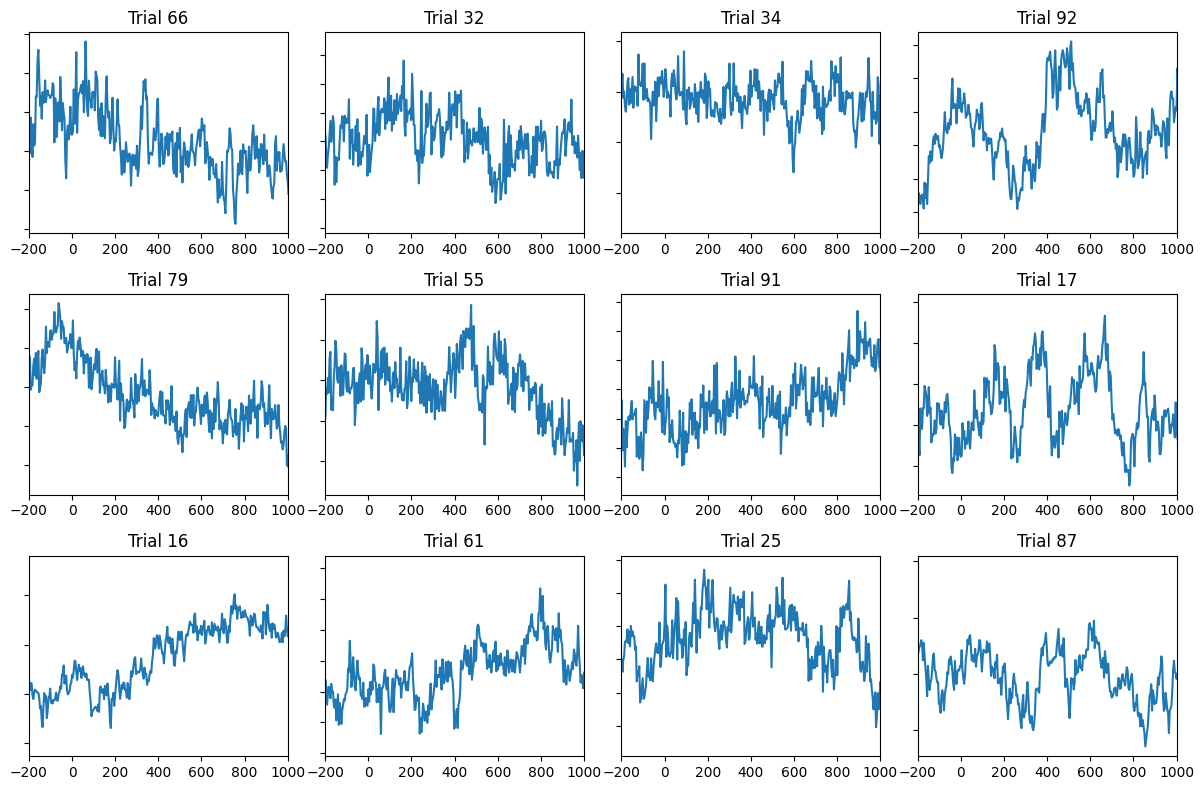

In [40]:
# Plot a few trials from one channel
which_channel_to_plot = 'FCz'
channel_index = get_channel_index(which_channel_to_plot, EEG['chanlocs'][0])
x_axis_limit = [-200, 1000]  # in ms
num_trials2plot = 12

plot_random_trials(EEG, channel_index, num_trials2plot, x_axis_limit)

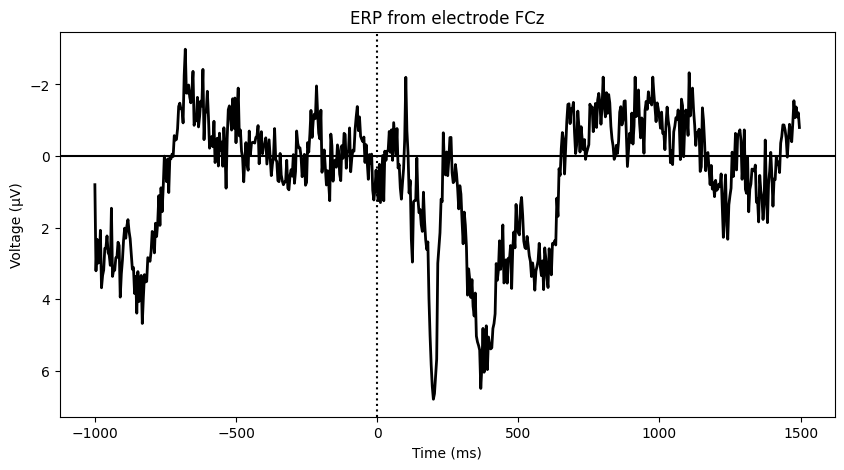

In [41]:
# Plot ERP (Event-Related Potential)
plot_erp(EEG, channel_index)

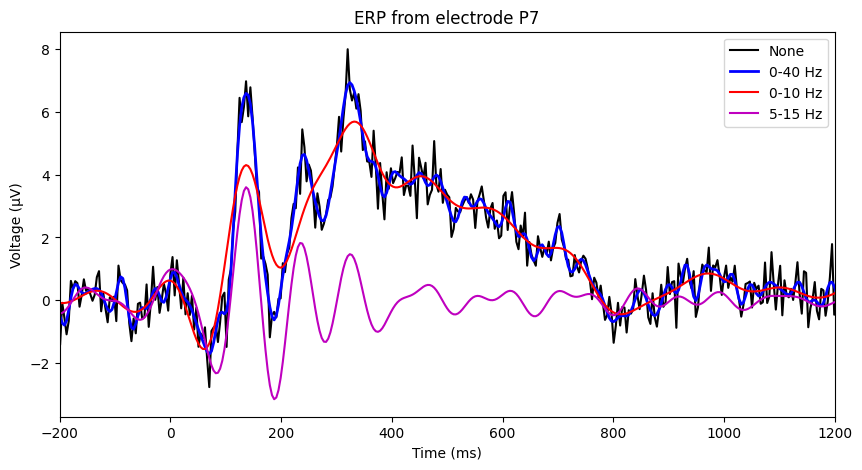

In [42]:
# Plot filtered ERPs
chan2plot = 'P7'
plot_filtered_erp(EEG, chan2plot)

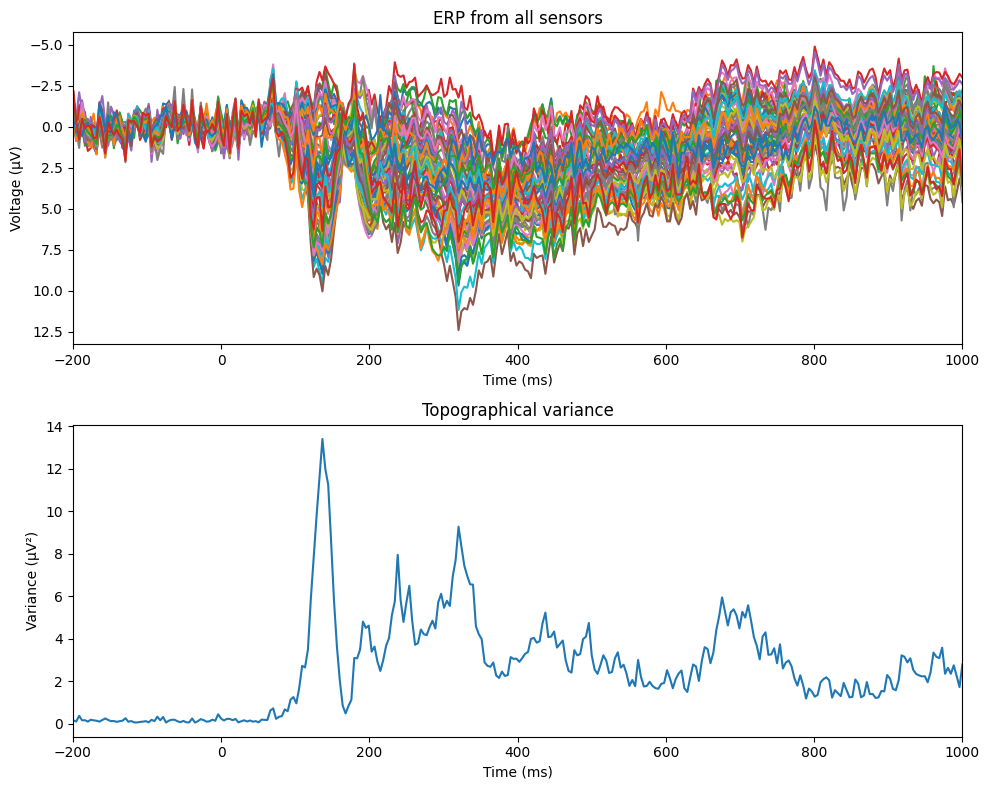

In [45]:
# Plot butterfly plot and topographical variance
plot_butterfly_topo_variance(EEG)

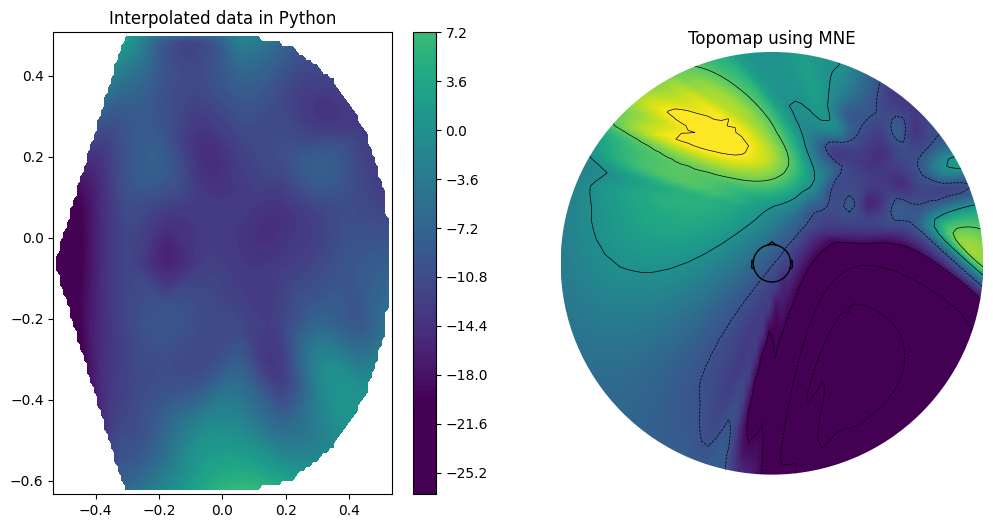

In [115]:
# Introduction to topographical plotting
def pol2cart(theta, radius):
    """Convert polar coordinates to Cartesian."""
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y

timepoint2plot = 100  # in ms
trial2plot = np.random.choice(get_eeg_trials(EEG), 1)[0]
color_limit = 20  # more-or-less arbitrary, but this is a good value

# Convert time point from ms to index
timepointidx = np.argmin(np.abs(get_eeg_times(EEG) - timepoint2plot))

# Get X and Y coordinates of electrodes
th = np.pi / 180 * np.array([chan['theta'] for chan in EEG['chanlocs'][0]])
radii = np.array([chan['radius'] for chan in EEG['chanlocs'][0]])
electrode_locs_X, electrode_locs_Y = pol2cart(th, radii)

# Flatten the electrode location arrays
electrode_locs_X = electrode_locs_X.flatten()
electrode_locs_Y = electrode_locs_Y.flatten()

# Interpolate to get a nice surface
interpolation_level = 100
interpX = np.linspace(min(electrode_locs_X), max(electrode_locs_X), interpolation_level)
interpY = np.linspace(min(electrode_locs_Y), max(electrode_locs_Y), interpolation_level)
gridX, gridY = np.meshgrid(interpX, interpY)

# Interpolate the data on a 2D grid
eeg_data_at_timepoint = get_eeg_data(EEG)[:, timepointidx, trial2plot]
interpolated_EEG_data = griddata((electrode_locs_X, electrode_locs_Y), eeg_data_at_timepoint, (gridX, gridY), method='cubic')

# Plot the interpolated data
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].contourf(interpY, interpX, interpolated_EEG_data, 100, cmap='viridis', vmin=-color_limit, vmax=color_limit)
axs[0].set_title('Interpolated data in Python')
plt.colorbar(im, ax=axs[0])

# Get the channel names from the EEG data
channel_names = [chan['labels'][0] for chan in EEG['chanlocs'][0]]

# Find the indices of the channels in the layout
layout = read_layout('EEG1005')
layout_names = [name for name in layout.names]
pos_idx = [layout_names.index(name) for name in channel_names if name in layout_names]

# Select the positions of the channels present in the data
selected_pos = layout.pos[pos_idx, :2]  # We only need the x and y coordinates

# Plot using MNE's topomap function
mask = np.zeros((len(eeg_data_at_timepoint),), dtype=bool)
plot_topomap(eeg_data_at_timepoint, selected_pos, sensors=False, mask=mask, cmap='viridis', vlim=(-color_limit, color_limit), axes = axs[1], show=False)
axs[1].set_title('Topomap using MNE')

plt.show()

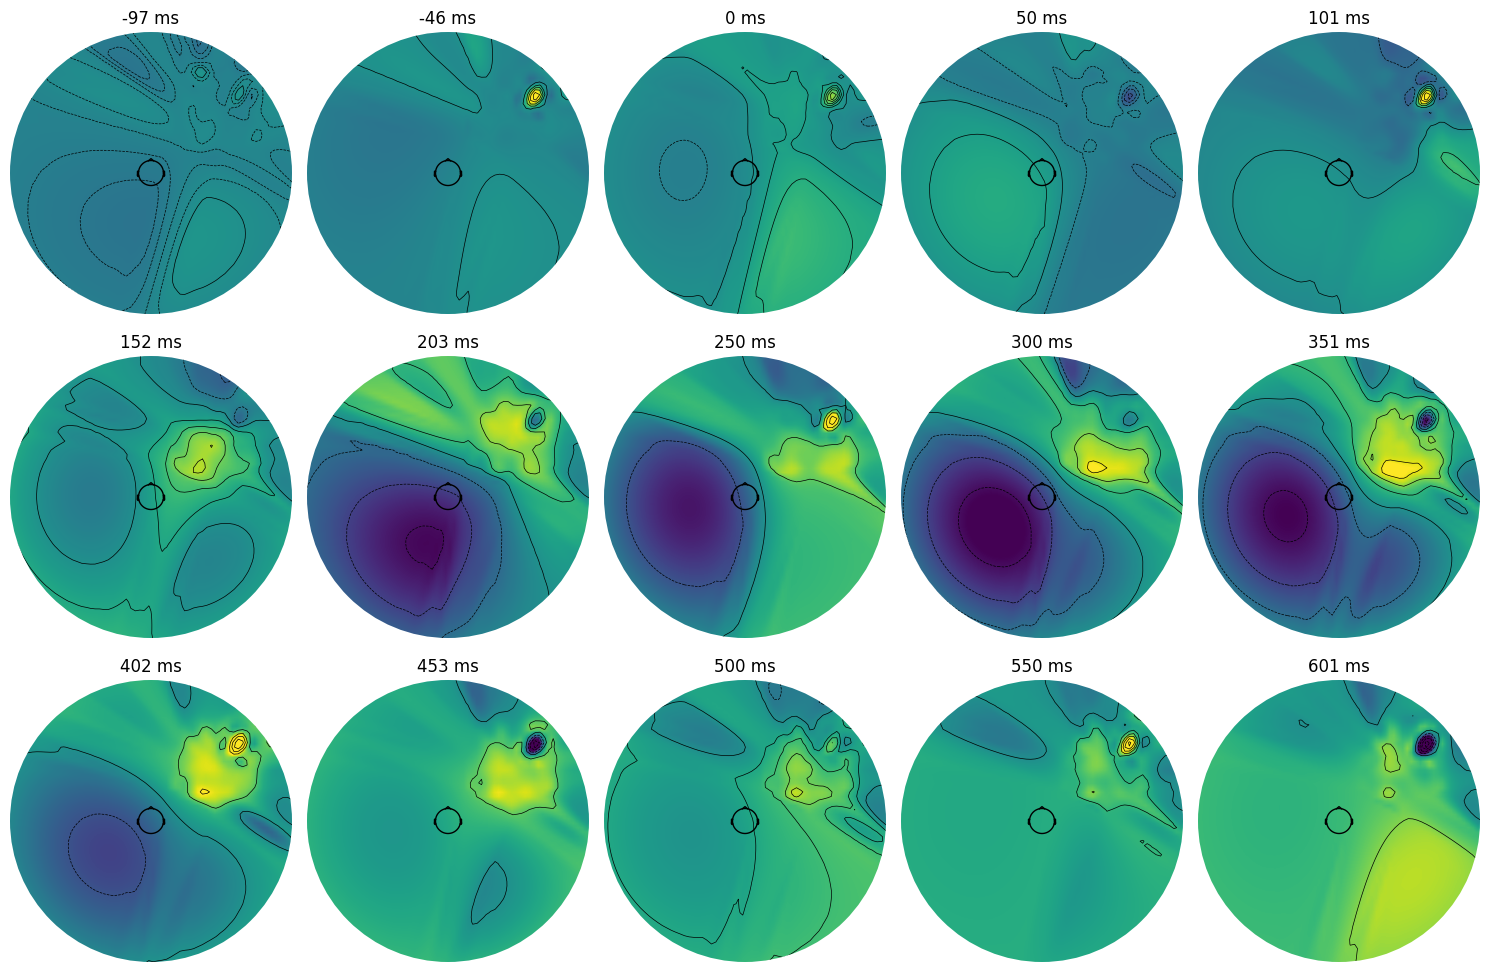

In [118]:
# Figure 9.5: Topographical plots at different time points
times2plot = np.searchsorted(get_eeg_times(EEG), np.arange(-100, 650, 50))

fig, axs = plt.subplots(3, 5, figsize=(15, 10))
for i, time_idx in enumerate(times2plot):
    ax = axs[i // 5, i % 5]  # Determine the subplot position
    eegdata2plot = np.mean(get_eeg_data(EEG)[:, time_idx, :], axis=1)
    eegdata2plot[get_channel_index('FC4', EEG['chanlocs'][0])] = np.random.randn() * 10
    plot_topomap(eegdata2plot, selected_pos, vlim=(-8, 8), sensors=False, cmap='viridis', axes=ax, show=False)
    ax.set_title(f'{int(get_eeg_times(EEG)[time_idx])} ms')
fig.tight_layout()
plt.show()

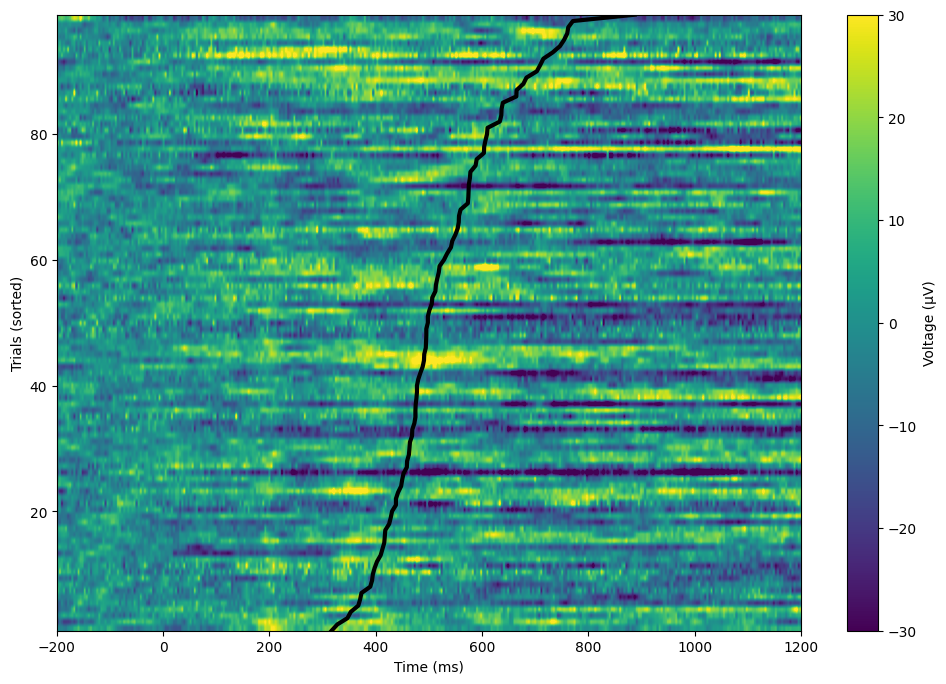

In [244]:
# Figure 9.6: Sorting trials by reaction times or EEG data
useRTs = True  # Change to False to sort by EEG data

# Get RTs from each trial
rts = np.array([epoch['eventlatency'][0][np.where(np.array(epoch['eventlatency'][0]) == 0)[0][0] + 1][0][0] for epoch in EEG['epoch'][0]])

# Find the sorting indices for RTs
if useRTs:
    rts_idx = np.argsort(rts)
else:
    rts_idx = np.argsort(get_eeg_data(EEG)[46, 334, :])

# Plot sorted data
plt.figure(figsize=(12, 8))
plt.imshow(get_eeg_data(EEG)[46, :, rts_idx], aspect='auto', extent=[min(get_eeg_times(EEG)), max(get_eeg_times(EEG)), 1, get_eeg_trials(EEG)], vmin=-30, vmax=30, origin="lower", cmap='viridis')
plt.xlim([-200, 1200])
plt.xlabel('Time (ms)')
plt.ylabel('Trials (sorted)')
plt.colorbar(label='Voltage (μV)')

# Also plot the RTs on each trial
if useRTs:
    plt.plot(rts[rts_idx], np.arange(1, get_eeg_trials(EEG) + 1), 'k', linewidth=3)
plt.show()